# [E-03] 카메라 스티커 앱 만들기

* 평가 기준
    * 자기만의 카메라앱 기능 구현을 완수하였다: 원본에 스티커 사진이 정상적으로 합성되었다.
    * 스티커 이미지를 정확한 원본 위치에 반영하였다: 정확한 좌표계산을 통해 고양이 수염이 위치가 원본 얼굴에 잘 어울리게 출력되었다.
    * 카메라 스티커앱을 다양한 원본이미지에 적용했을 때의 문제점을 체계적으로 분석하였다: 얼굴각도, 이미지 밝기, 쵤영거리 등 다양한 변수에 따른 영향도를 보고서에 체계적으로 분석하였다.

* png 파일은 배경이 투명해서 배경 이미지 위에 png파일을 얹어 두 이미지를 합성시킬 수 있다.
* jpeg 등과 같은 다른 이미지 파일을 사용하면 배경을 지우는 등 추가 처리가 필요하므로 배경이 없는 png 파일을 사용하는 것이 훨씬 빠르고 간편하다.

* 눈, 코, 입과 같은 얼굴 각각의 위치를 찾아내는 기술을 랜드마크(landmark) 또는 조정(alignment)이라고 한다. **(조금 더 큰 범위로는 keypoint detection)**


### 사진 준비하기

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

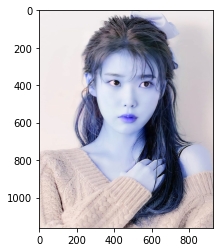

In [2]:
image_path = os.getenv('HOME') + '/aiffel/camera_sticker/images/iu.png'
img_bgr = cv2.imread(image_path)
img_show = img_bgr.copy()
plt.imshow(img_bgr)
plt.show()

* 알게된 것
    * 이미지가 파란 빛을 띄는 이유: opencv는 이미지 채널을 BGR을 사용해서 원본 사진의 붉은 색은 푸른색으로, 푸른색은 붉은 색으로 바뀌어서 출력된다. -> 보정 처리를 해줘야 함.

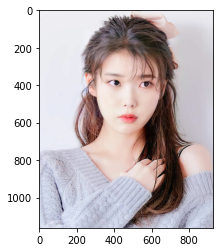

In [3]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

* 알게된 것
    * cv2.cvtColor(그림BGR, cv2.COLOR_BGR2RGB)
        * opencv 이미지를 matplotlib로 화면에 출력하는 방법.
        * 그럼 cv2.imshow로 바로 읽으면 되지 않나? -> 대부분의 다른 이미지 처리 라이브러리는 rgb 순서를 사용하기 때문에 변환해주는 게 편함.
        * https://codesample-factory.tistory.com/426

* 그럼 왜 opencv는 bgr을 쓰는 걸까
    * 찾아보니 특별한 이유는 없어보인다. 그냥 단지 그 시기 카메라 산업 개발자들이 bgr을 많이 썼기 때문에 아무 생각 없이 선택한 것이라고 함.
    * https://blog.xcoda.net/102

### 얼굴 검출(face detection)

* dlib의 face detector는 HOG(Histogram of Oriented Gradients)와 SVM(Support Vector Machine)을 사용해서 얼굴을 찾는다.

* HOG(Histogram of Oriented Gradients)
    * 이미지에서 생상의 변화량을 나타낸 것
    * 이미지에서 단순히 생각값만 가지고 할 수 있는 일이 제한적이었기 때문에 색상의 변화량을 계산한 HOG는 큰 도움이 되었다. -> 이미지로부터 물체의 특징만 잘 잡아내는 능력을 갖출 수 있음.

* SVM(Support Vector Machine)
    * 선형 분류기
    * 이미지를 다차원 공간의 한 벡터라고 보면 여러 이미지는 여러 벡터가 된다.
    * 위 여러 벡터를 잘 구분짓는 방법임
    * 이 노드에서는 얼굴이냐 아니냐를 구분하는 것이 중요.
    * 이미지의 색상만 가지고는 큰 힘을 발휘하지 못하지만 HOG를 통해 벡터로 만들어진 후라면 좋음.

* sliding window
    * 작은 영역을 이동해가며 이미지를 확인하는 방법
    * 이미지가 크면 클수록 오래걸림 -> 딥러닝이 필요한 이유

In [4]:
# detector 선언
detector_hog = dlib.get_frontal_face_detector()

In [5]:
# detector_hog를 이용해 얼굴의 바운딩 박스를 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)

* 알게된 것
    * upsampling
        * 데이터의 크기를 키우는 것(반대의 의미로 down sampling)
    * 이미지 피라미드
        * 같은 이미지의 서로 다른 사이즈 set
        * 만약 이미지에서 얼굴을 찾을 때 다양한 사이즈에서 찾으면 더욱 정확하게 찾을 수 있다.

rectangles[[(290, 290) (675, 675)]]


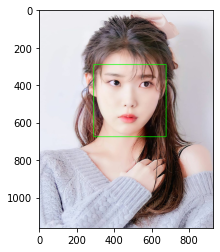

In [6]:
# 바운딩 박스로 찾은 얼굴 출력
print(dlib_rects)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

* 알게된 것
    * cv2.rectangle(이미지 파일, 시작점 좌표, 종료점 좌표, 색상, 선 두께, 선 종류)
    https://copycoding.tistory.com/146

### 얼굴 랜드마크

* 이목구비 위치를 추론하는 것
    * Dlib landmark localization
        * 잘라진 얼굴 이미지에서 68개 이목구비 위치를 찾는다.
        * 점의 개수는 데이터셋과 논문마다 다름

* Object Keypoint Estimation
    * 객체 내부의 점을 찾는 기술
    * top_down: 바운딩 박스를 찾고, 박스 내부의 keypoint를 예측
    * bottom_top: 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화 해서 박스 생성
    * 박스 안에 있는 걸 찾냐, 아니면 전체적인 특징을 찾고 박스를 만드냐

In [7]:
model_path = os.getenv('HOME') + '/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [8]:
list_landmarks = []

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)
    
print(len(list_landmarks[0]))

68


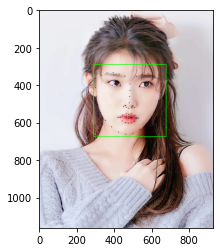

In [9]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 0, 0), -1)
        
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [10]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index는 30
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(479, 494)
(x,y) : (479,301)
(w,h) : (386,386)


### 스티커 적용해보기

In [11]:
sticker_path = os.getenv('HOME') + '/aiffel/camera_sticker/images/cat.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w, h))
print(img_sticker.shape)

(386, 386, 3)


* 알게된 것
    * resize: 위 코드에서 정의한 바운딩박스의 너비로 스티커 사이즈를 조절

In [12]:
refined_x = x-w//2
refined_y = y
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (286,301)


In [13]:
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (286,301)


In [14]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

* 알게된 것
    * np.where의 의미: img_sticker가 255(흰색)이면, sticker_area, 즉 원래 사진을 보여주고, 아니면 스티커를 보여준다.

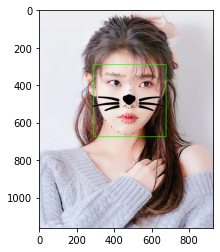

In [15]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

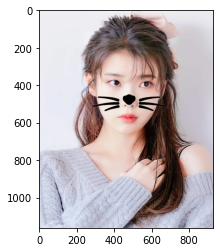

In [16]:
# 바운딩 박스와 랜드마크 제거
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### 각도와 거리가 다양한 이미지

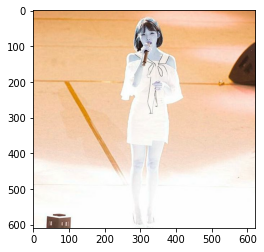

In [17]:
# 거리가 먼 이미지
iu_far_path = os.getenv('HOME') + '/aiffel/camera_sticker/images/iu_6.png'
img_bgr = cv2.imread(iu_far_path)
img_show = img_bgr.copy()
plt.imshow(img_bgr)
plt.show()

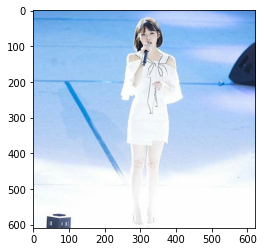

In [18]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [19]:
detector_hog = dlib.get_frontal_face_detector()

In [20]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)

rectangles[[(296, 55) (348, 107)]]


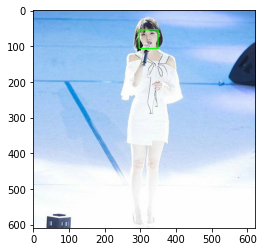

In [21]:
print(dlib_rects)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [22]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [23]:
list_landmarks = []

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


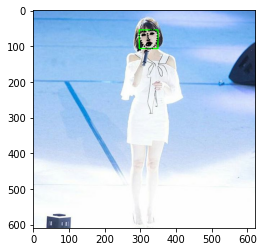

In [24]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 0, 0), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [25]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(321, 79)
(x,y) : (321,53)
(w,h) : (53,53)


In [26]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(53, 53, 3)


In [27]:
refined_x = x-w//2
refined_y = y
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (295,53)


In [28]:
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (295,53)


In [29]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

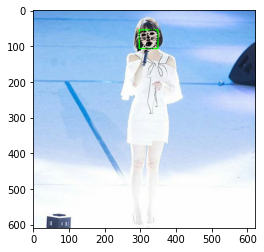

In [30]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

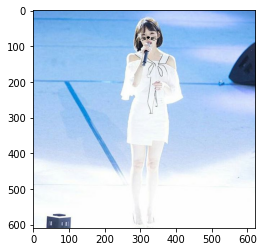

In [31]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

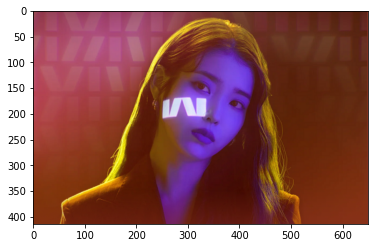

In [32]:
# 각도가 다른 이미지
iu_different_path = os.getenv('HOME') + '/aiffel/camera_sticker/images/iu_5.png'
img_bgr = cv2.imread(iu_different_path)
img_show = img_bgr.copy()
plt.imshow(img_bgr)
plt.show()

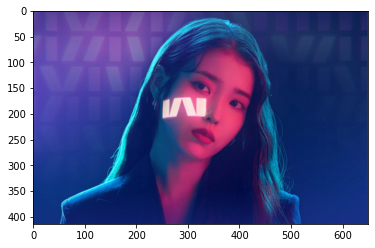

In [33]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [34]:
detector_hog = dlib.get_frontal_face_detector()

In [35]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)

rectangles[[(270, 116) (425, 270)]]


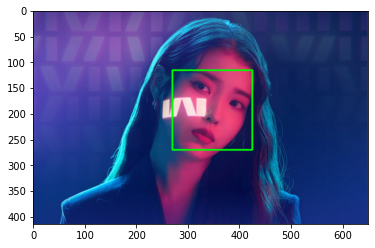

In [36]:
print(dlib_rects)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [37]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [38]:
list_landmarks = []

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


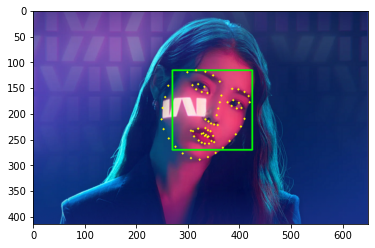

In [39]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [40]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30])
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(356, 203)
(x,y) : (356,126)
(w,h) : (156,156)


In [41]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(156, 156, 3)


In [42]:
refined_x = x-w//2
refined_y = y
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (278,126)


In [43]:
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (278,126)


In [44]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

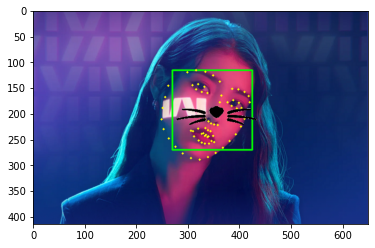

In [45]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

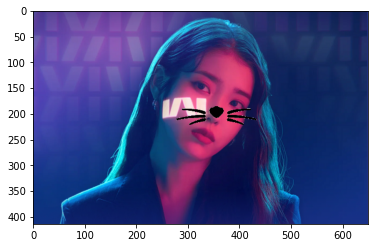

In [46]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

* 여기까지 느낀 점
    * 거리가 먼 사진의 경우 바운딩 박스와 랜드마크가 잘못찍히거나 하는 경우는 없는 것 같다. 다만 한 번 잘 나온 것으로 확신하기엔 무리가 있어보인다. 관건은 얼굴 좌표와 그에 따라 계산한 얼굴 영역에 맞춰 스티커 사이즈를 조절하는 부분인 것 같은데 이 또한 영역에 대한 부분만 잘 맞춰주면 거리가 멀어도 스티커는 잘 적용되는 것 같다.
    * 각도가 다른 사진으로 수행했을 때가 문제인데, 얼굴 각도에 맞게 스티커가 적용되지 않는다. 그래서 생각한 방법이 있는데, 이 주피터 노트북엔 마지막에 추가할 예정이지만, 다른 주피터 노트북에서는 각도가 다르게 찍힌 사진이 아니라 cv2.getRotationMatrix2D() 메서드로 각도를 임의적으로 바꿔 수행해보려고 시도했었다. 퍼실님이 그런 의미가 아니었다고 말씀해주셔서 그냥 공부했다 치고 코드만 추가해놓으려고 했는데, 이 메서드를 활용해 스티커의 각도를 조정해서 적용하면 되지 않을까 생각이 들었다.
    * 이미지 밝기 문제: 멀리서 찍힌 이미지와 같은 맥락으로 이목구비를 인식할 정도로 어둡다면 큰 문제는 없는 것 같다. 랜드마크를 찍을 수 있다면 스티커를 적용하는 데에는 문제가 없어보인다. 역시 중요한 건 얼굴의 각도와 그에 맞게 스티커를 적용하는 것이 어려워보인다.

### 스티커 회전시키기

In [47]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(156, 156, 3)


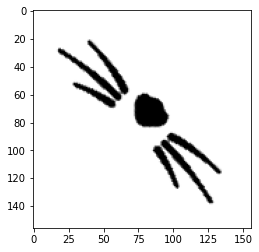

In [48]:
height, width = img_sticker.shape[:2]

# 이미지 중앙을 기준으로 반시계 방향 45도 회전
M = cv2.getRotationMatrix2D((width/2.0, height/2.0), # 회전할 때의 중심점
                           -45, # 회전 각도(양수=반시계, 음수=시계방향)
                           1)  # 이미지 배율

# 회전 행렬 M을 이미지에 적용
img_sticker_rotate = cv2.warpAffine(img_sticker, M, (width, height), flags=cv2.INTER_LINEAR,borderValue=(255,255,255))

plt.imshow(img_sticker_rotate)
plt.show()

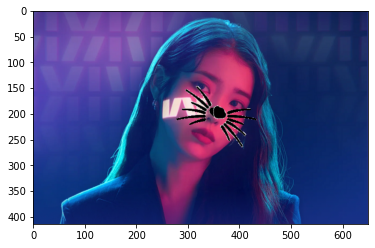

In [49]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker_rotate.shape[0], refined_x:refined_x+img_sticker_rotate.shape[1]]
img_bgr[refined_y:refined_y +img_sticker_rotate.shape[0], refined_x:refined_x+img_sticker_rotate.shape[1]] = \
    np.where((img_sticker_rotate==255),sticker_area,img_sticker_rotate).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

* 문제점
    * 갑자기 고양이 털이 늘어났다.... 왜 이런 결과가 나왔는지 모르겠다
    * 이미지 회전 후 생긴 모서리 쪽 검은 부분이 원본 이미지에도 적용됨. 잘라내야하는 건지 아니면 적용할 때 흰 부분을 뺀 것 처럼 검은 부분도 뺄 수 있는지 모르겠다.
    
* 해결
    * flags=cv2.INTER_LINEAR,borderValue=(255,255,255) 코드를 warpAffine 메서드에 추가해 배경을 전부 하얀색으로 바꿔줬다. 다만 수염의 수가 늘어나는 건 왜인지 모르겠다.
    * https://velog.io/@dldndyd01/OpenCV-%EC%9D%B4%EB%AF%B8%EC%A7%80-%ED%9A%8C%EC%A0%84%EC%A4%91%EC%95%99-%EA%B8%B0%EC%A4%80-%ED%9A%8C%EC%A0%84-cv2.getRotationMatrix2D-%EC%96%BC%EA%B5%B4-%ED%9A%8C%EC%A0%84-%EA%B0%81%EB%8F%84-%EA%B5%AC%ED%95%98%EA%B8%B0

### opencv를 활용해 이미지 회전 시키기

* 루브릭 평가 기준 중 다양한 각도를 잘못 이해해서 시도했던 이미지 회전 코드들인데 아깝기도하고 바운딩 박스가 얼굴 인식을 잘 못하는 것 처럼 보여 생각해볼 여지가 있는 것 같아 첨부.

In [50]:
yoon_image_path = os.getenv('HOME') + '/aiffel/camera_sticker/images/iu.png'
img = cv2.imread(yoon_image_path)
img_show = img.copy()

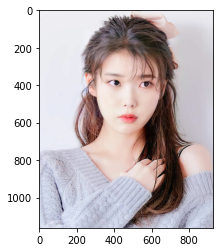

In [51]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

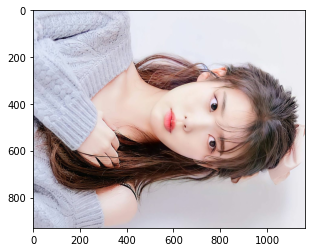

In [52]:
img_rotate = cv2.rotate(img_rgb, cv2.ROTATE_90_CLOCKWISE)
plt.imshow(img_rotate)
plt.show()

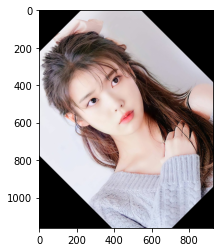

In [53]:
height, width = img_rgb.shape[:2]

# 이미지 중앙을 기준으로 반시계 방향 45도 회전
M = cv2.getRotationMatrix2D((width/2.0, height/2.0), # 회전할 때의 중심점
                           45, # 회전 각도(양수=반시계, 음수=시계방향)
                           1)  # 이미지 배율

# 회전 행렬 M을 이미지에 적용
img_rotate = cv2.warpAffine(img_rgb, M, (width, height))

plt.imshow(img_rotate)
plt.show()

In [54]:
detoctor_hog_rotate = dlib.get_frontal_face_detector()

In [55]:
img_rotate_rgb = cv2.cvtColor(img_rotate, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)

rectangles[[(290, 290) (675, 675)]]


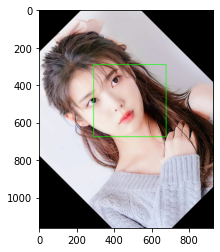

In [56]:
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_rotate_rgb, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_rotate_rgb, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

* 바운딩 박스가 얼굴을 잘 찾지 못한다. 회전하기 전 이미지를 기준으로 찾는 것 같은데 해결 방법은 아직 모르겠음.

* 얼굴 각도, 이미지 밝기, 촬영 거리와 같은 이미지에서 볼 수 있는 다양한 변수가 얼마나 영향을 미치는지에 대해 생각해봤을 때, 가장 중요하게 체크해야할 부분은 이목구비를 잘 인식했느냐라고 생각한다. 이미지가 너무 어둡거나 너무 밝거나, 또는 너무 멀거나 가까워서 이목구비를 알아볼 수 없을 정도라면 스티커를 적용할 좌표를 찾을 수 없을 것이다. 다양한 이미지로 프로젝트를 수행해본 결과 다양한 변수가 있더라도 랜드마크만 잘 된다면 큰 문제는 없을 거라고 보임.

* 이번 노드에서 가장 어려웠던 부분은 좌표에 대한 개념과 각도 조절이었다.
    * 좌표
        * 좌표를 계산하는 부분에서 어떤 식으로 계산하는지 좀 더 공부해야할 것 같다.
    * 각도 조절
        * 각도 조절할 때 사용했던 메서드를 다음에도 쓸 수 있을지는 모르겠다...